#Information



## Intelligent Systems - Assignment 2 

- Member Names: **Mireya Quintana y Haizea Rodriguez**
- Group ID: **C**
- Assignment: **02**
- Date: **26/03/2021**
- Time spent in the assignment: **12h**
- Proportion of effort done by members of the group: **50/50**
- Doubts and difficulties that arose during the realization: **The imposibility to solve robot3 and robot4 because we needed more iterations.**

---

**General instructions**
 1. If you use a function of a certain library, do not forget to include in the packages vector
 2. Do not forget to comment on the code, especially those non-trivial commands (part of the rating depends on the cleaning of the code)
 3. It is strongly recommended to test any implemented function in order to    check for its proper operation

---

 **Submission**
- Print the notebook in a PDF file with all the sections expanded and all the cells executed, in a way all the code can be seen, and all the results are shown.
- Save the notebook as ipynb file.
- Submit both files, in addition to any input file needed for its execution in a zip folder into ALUD

---

**Evaluation**
- Total Evaluation - 22,5%.
  - Correct and error-free execution - 15%
  - Documentation of analysis of results - 7.5%.

---
**Deadline**
March 29th

## Problem statement

This project is inspired in a problem proposed by Google in its Hash Code 2020's [final round](https://storage.googleapis.com/coding-competitions.appspot.com/HC/2020/hashcode2020_final_round.pdf):
- We have to define the movements that a robotic arm has to make in order to assemble the components of a mobile phone.
- The problem scenario is an MxN grid in which an anchor point for the robot is identified, the assembly points that the robot must visit, and boxes that cannot be crossed (or forbidden).
- With each move, the robot extends and occupies the squares it crosses.

---

**Objective**

- The objective is to determine the sequence of movements to be made by the robot to pass through all the assembly points, respecting the order of passage through each assembly point and without crossing forbidden boxes or boxes occupied by the robot's extension.
- The actions that the robot can perform is to move (up, down, right and left) without leaving the grid and without crossing forbidden squares or squares occupied by its extension (it cannot contract itself).

---

**Description of the problem**

Each instance of the problem is defined as a text file with the following information (on 4 lines):
1. Grid height and width: M,N
2. Robot assembly position: X0,Y0
3. List (ordered) of 1 or more assembly points: X1,Y1; X2,Y2; ...
4. List of 0 or more forbidden boxes: XF1,YF1;XF2,YF2;...

**IMPORTANT: The result is the list of actions that the robot executes to extend and pass through the assembly boxes (in the defined order).**


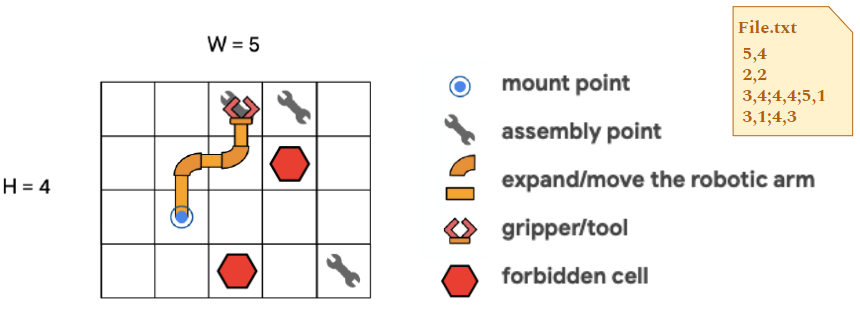

---

**You are asked to**

1. Analyse the problem to be solved. 
2. Formulate the problem and define:
  - Data structures that define the state of the problem.
  - Specific number of actions; and for each one of them: Conditions, Effect and Cost
3. Modify the Problem formulation and experimentation sections in this notebook to:
  - Read scenario's information from text file.
  - Initialise the problem and solve it using different search algorithms.
4. Document the analysis of results
  - Compare the results of the different algorithms and justify them according to their characteristics: completeness, optimality and complexity.
  - Does the order of the assembly points affect the final result?






#Libraries

In [ ]:
# PLEASE, INCLUDE HERE IF YOU USE ANY ADDITIONAL LIBRARY
packages = c("glue","ggplot2","gridExtra")
newpack  = packages[!(packages %in% installed.packages()[,"Package"])]
if(length(newpack)) install.packages(newpack)
a=lapply(packages, library, character.only=TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Search methods

🛑 (you don't have to modify here, just run)

## Node expansion and results analysis

In [ ]:
expand.node = function(node, actions.possible){
  newnodes = list()
  for (i in 1:nrow(actions.possible)){
    action = actions.possible[i, ]
    state = node$state
    if (is.applicable(state,action,problem)){
      newnode = list()
      newnode$parent  = node
      newnode$parent$parent = NULL
      newnode$state   = effect(state,action)    
      newnode$actions = rbind(node$actions,action)
      newnode$depth   = node$depth+1
      newnode$cost    = node$cost+get.cost(actions.possible[i,],state)
      newnode$evaluation = get.evaluation(newnode$state,problem)
      newnodes        = append(newnodes,list(newnode))
    }
  }
  return(newnodes)
}

In [ ]:
analyze.results = function(all,problem){
  results = data.frame()
  for (i in 1:length(all)){
    name = all[[i]]$name
    print(name)
    solution.found = any(!is.na(all[[i]]$state.final))
    if (any(solution.found)){
      # Checking the solution
      solution.length = length(all[[i]]$state.final$actions)
      solution.cost   = all[[i]]$state.final$cost
      print("  Solution Found! :)",quote = F)
      actions = all[[i]]$state.final$actions
      state.current = problem$state.initial
      print("Initial State: ")
      to.string(state.current)
      for (a in 1:length(actions)){
        action = actions[a]
        state.current = effect(state.current,action)  
        print(paste0("After applying action: ",action),quote = F)
        to.string(state.current)
      }
    }else{
      solution.length = -1
      solution.cost   = -1
      print("  No Solution Found :(")
    }
    
    number.expanded = length(all[[i]]$report$iteration)
    
    maximum.depth = max(all[[i]]$report$depth.of.expanded)
    
    maximum.frontier = max(all[[i]]$report$nodes.frontier)
    
    results = rbind(results,data.frame(name=name,
                                       solution=solution.found,
                                       length=solution.length,
                                       cost=solution.cost,
                                       expanded=number.expanded,
                                       max.depth=maximum.depth,
                                       max.frontier=maximum.frontier))
    
  }
  return(results)
}

In [ ]:
plot.results = function(report,name.method,problem){
  # Generation of Graphics...
  plot1 = ggplot(report,aes(x=iteration,y=nodes.frontier))+geom_line(col="dodgerblue",size = 2)+
    labs(x="Iteration Number",
         y="Nodes stored in the frontier",
         title="Size of the Frontier",
         caption = "University of Deusto")+theme_minimal()
  
  plot2 = ggplot(report,aes(x=nodes.added.frontier))+geom_histogram(fill="dodgerblue",
                                                                    bins=length(unique(report$depth.of.expanded)),
                                                                    binwidth = 0.1)+
    labs(x="Number nodes added to frontier",
         y="Frequency",
         title="Frontier growth",
         caption = "University of Deusto")+theme_minimal()
  
  plot3 = ggplot(report,aes(x=depth.of.expanded))+geom_histogram(fill="dodgerblue",
                                                                 bins=length(unique(report$depth.of.expanded)),
                                                                 binwidth = 0.1)+
    labs(x="depth",
         y="Number of Nodes",
         title="depth of the nodes in the frontier",
         caption = "University of Deusto")+theme_minimal()
  
  grid.arrange(plot1,plot2,plot3,ncol=1,top=paste0(name.method,": ",problem$name))
}

## Search methods functions (included GBFS)



In [ ]:
Greedy.Best.First.Search = function(problem,
                               count.limit=100, 
                               count.print = 100, 
                               trace = FALSE){
  
  name.method = "GBFS"
  state.initial    = problem$state.initial
  state.final      = problem$state.final
  actions.possible = problem$actions.possible
  
  node = list(parent=c(),
              state=state.initial,
              actions=c(),
              depth=0,
              cost=0,
              evaluation=0)
  frontier = list(node)
  
  count = 1
  end.reason = 0
  report = data.frame(iteration=numeric(),
                      nodes.frontier=numeric(),
                      depth.of.expanded=numeric(),
                      nodes.added.frontier=numeric())
  
  
  while (count<=count.limit){
    
    if (count%%count.print==0){
      print(paste0("Count: ",count,", Nodes in the frontier: ",length(frontier)), quote = F)
    }
    
    if (length(frontier)==0){
      end.reason = "Frontier"
      break
    }
    
    firstnode = frontier[[1]]
    frontier[[1]] = NULL
    
    if (trace){
      print(" ",quote = F)
      print("------------------------------", quote = F)
      print("State extracted from frontier:", quote = F)
      to.string(firstnode$state)
      print(paste0("(depth=",firstnode$depth,", cost=",firstnode$depth,", eval=",firstnode$evaluation,")"),quote = F)
    }
    
    if (is.final.state(firstnode$state,state.final)){
      end.reason = "Sollution"
      break
    }
    
    newnodes = expand.node(firstnode, actions.possible)
    
    frontier = c(frontier,newnodes)
    nodes.added.frontier = length(newnodes)
    
    # Line added to order the frontier according with EVALUATION
    frontier = frontier[order(sapply(frontier,function (x) x$evaluation))]
    
    if(trace){
      print(paste0("Total states in the frontier: ", length(frontier)),quote = F)
    }
    
    report = rbind(report,
                   data.frame(iteration = count,
                              nodes.frontier = length(frontier),
                              depth.of.expanded = firstnode$depth,
                              nodes.added.frontier = nodes.added.frontier))
    
    count = count+1
  }
  
  
  result = list()
  result$report = report
  result$name = name.method
  
  # Show the obtained (or not) final solution
  if (end.reason == "Sollution"){
    print("Solution found!!", quote = F)
    to.string(firstnode$state)
    print("Actions: ", quote = F)
    print(firstnode$actions, quote = F)
    result$state.final = firstnode
  } else{
    if (end.reason == "Frontier"){
      print("Empty frontier. No sollution found", quote = F)
    } else{
      print("Maximum Number of iterations reached. No sollution found", quote = F)
    }
    result$state.final = NA
  }
  
  plot.results(report,name.method,problem)
  
  return(result)
}


In [ ]:
Breadth.First.Search = function(problem,
                                count.limit = 100, 
                                count.print = 100, 
                                trace = FALSE, 
                                graph.search = FALSE){
  
  name.method = paste0("BFS", ifelse(graph.search,"+GS",""))
  state.initial    = problem$state.initial
  state.final      = problem$state.final
  actions.possible = problem$actions.possible
  
  node = list(parent=c(),
              state=state.initial,
              actions=c(),
              depth=0,
			        cost=0)
  frontier = list(node)

  if (graph.search){
    expanded = list()     
  }
  count = 1
  end.reason = 0
  report = data.frame(iteration=numeric(),
                      nodes.frontier=numeric(),
                      depth.of.expanded=numeric(),
                      nodes.added.frontier=numeric())
  
  
  while (count<=count.limit){
    if (count%%count.print==0){
      print(paste0("Count: ",count,", Nodes in the frontier: ",length(frontier)), quote = F)
    }
    
    if (length(frontier)==0){
      end.reason = "Frontier"
      break
    }
    
    firstnode = frontier[[1]]
    frontier[[1]] = NULL
    if(graph.search){
      expanded = append(expanded,list(firstnode))
    }
    
    if (trace){
      print(" ",quote = F)
      print("------------------------------", quote = F)
      print("State extracted from frontier:", quote = F)
      to.string(firstnode$state)
      print(paste0("(depth=",firstnode$depth,", cost=",firstnode$depth,")"),quote = F)
    }
    
    if (is.final.state(firstnode$state,state.final)){
      end.reason = "Sollution"
      break
    }
    
    newnodes = expand.node(firstnode, actions.possible)
    
    if (!graph.search){
		  frontier = c(frontier,newnodes)
  		nodes.added.frontier = length(newnodes)
  		if (length(newnodes)){
    		for (i in 1:length(newnodes)){
    			newnode = newnodes[[i]]		  
    			if (trace){
    			  print(paste0("State added to frontier: - (depth=",newnode$depth,", cost=",newnode$depth,")"),quote = F)
    			  to.string(newnode$state)
    			}
    		}
  		}
    }else{
      nodes.added.frontier = 0
      if (length(newnodes)){
        for (i in 1:length(newnodes)){
          newnode = newnodes[[i]]
          if (!any(sapply(frontier,function (x) identical(x$state,newnode$state)))){
            if (!any(sapply(expanded,function (x) identical(x$state,newnode$state)))){
        				frontier = append(frontier,list(newnode))
        				nodes.added.frontier = nodes.added.frontier + 1
                if (trace){
                  print(paste0("State added to frontier: - (depth=",newnode$depth,", cost=",newnode$depth,")"),quote = F)
                  to.string(newnode$state)
                }
            }
          }
        }
      }
    }
    
    if(trace){
      print(paste0("Total states in the frontier: ", length(frontier)),quote = F)
    }
    
    report = rbind(report,
                   data.frame(iteration = count,
                              nodes.frontier = length(frontier),
                              depth.of.expanded = firstnode$depth,
                              nodes.added.frontier = nodes.added.frontier))
    
    count = count+1
  }
  
  
  result = list()
  result$report = report
  result$name = name.method

  # Show the obtained (or not) final solution
  if (end.reason == "Sollution"){
    print("Solution found!!", quote = F)
    to.string(firstnode$state)
    print("Actions: ", quote = F)
    print(firstnode$actions, quote = F)
    result$state.final = firstnode
  } else{
    if (end.reason == "Frontier"){
      print("Empty frontier. No sollution found", quote = F)
    } else{
      print("Maximum Number of iterations reached. No sollution found", quote = F)
    }
      result$state.final = NA
  }
  
  plot.results(report,name.method,problem)
  
  return(result)
}


In [ ]:
Uniform.Cost.Search = function(problem,
                               count.limit=100, 
                               count.print = 100, 
                               trace = FALSE){
  
  name.method = "UCS"
  state.initial    = problem$state.initial
  state.final      = problem$state.final
  actions.possible = problem$actions.possible
  
  node = list(parent=c(),
              state=state.initial,
              actions=c(),
              depth=0,
              cost=0)
  frontier = list(node)

  count = 1
  end.reason = 0
  report = data.frame(iteration=numeric(),
                      nodes.frontier=numeric(),
                      depth.of.expanded=numeric(),
                      nodes.added.frontier=numeric())
  
  
  while (count<=count.limit){
    
    if (count%%count.print==0){
      print(paste0("Count: ",count,", Nodes in the frontier: ",length(frontier)), quote = F)
    }
    
    if (length(frontier)==0){
      end.reason = "Frontier"
      break
    }
    
    firstnode = frontier[[1]]
    frontier[[1]] = NULL

    if (trace){
      print(" ",quote = F)
      print("------------------------------", quote = F)
      print("State extracted from frontier:", quote = F)
      to.string(firstnode$state)
      print(paste0("(depth=",firstnode$depth,", cost=",firstnode$depth,")"),quote = F)
    }
    
    if (is.final.state(firstnode$state,state.final)){
      end.reason = "Sollution"
      break
    }
    
    newnodes = expand.node(firstnode, actions.possible)
    
    frontier = c(frontier,newnodes)
    nodes.added.frontier = length(newnodes)
    
    # Line added to order the frontier according with the evaluation function
    frontier = frontier[order(sapply(frontier,function (x) x$evaluation))]

    if(trace){
      print(paste0("Total states in the frontier: ", length(frontier)),quote = F)
    }
    
    report = rbind(report,
                   data.frame(iteration = count,
                              nodes.frontier = length(frontier),
                              depth.of.expanded = firstnode$depth,
                              nodes.added.frontier = nodes.added.frontier))
    
    count = count+1
  }
  
  
  result = list()
  result$report = report
  result$name = name.method
  
  # Show the obtained (or not) final solution
  if (end.reason == "Sollution"){
    print("Solution found!!", quote = F)
    to.string(firstnode$state)
    print("Actions: ", quote = F)
    print(firstnode$actions, quote = F)
    result$state.final = firstnode
  } else{
    if (end.reason == "Frontier"){
      print("Empty frontier. No sollution found", quote = F)
    } else{
      print("Maximum Number of iterations reached. No sollution found", quote = F)
    }
    result$state.final = NA
  }
  
  plot.results(report,name.method,problem)
  
  return(result)
}


In [ ]:
Depth.First.Search = function(problem,
                                count.limit=100, 
                                count.print = 100, 
                                trace = FALSE, 
                                graph.search = FALSE){
  
  name.method = paste0("DFS", ifelse(graph.search,"+GS",""))
  state.initial    = problem$state.initial
  state.final      = problem$state.final
  actions.possible = problem$actions.possible
  
  node = list(parent=c(),
              state=state.initial,
              actions=c(),
              depth=0,
			        cost=0)
  frontier = list(node)

  if (graph.search){
    expanded = list()     
  }
  count = 1
  end.reason = 0
  report = data.frame(iteration=numeric(),
                      nodes.frontier=numeric(),
                      depth.of.expanded=numeric(),
                      nodes.added.frontier=numeric())
  
  
  while (count<=count.limit){
    
    if (count%%count.print==0){
      print(paste0("Count: ",count,", Nodes in the frontier: ",length(frontier)), quote = F)
    }
    
    if (length(frontier)==0){
      end.reason = "Frontier"
      break
    }
    # We only change here with regards to BFS
    firstnode = frontier[[length(frontier)]]
    frontier[[length(frontier)]] = NULL
    if(graph.search){
      expanded = append(expanded,list(firstnode))
    }
    
    if (trace){
      print(" ",quote = F)
      print("------------------------------", quote = F)
      print("State extracted from frontier:", quote = F)
      to.string(firstnode$state)
      print(paste0("(depth=",firstnode$depth,", cost=",firstnode$depth,")"),quote = F)
    }
    
    if (is.final.state(firstnode$state,state.final)){
      end.reason = "Sollution"
      break
    }
    
    newnodes = expand.node(firstnode, actions.possible)
    
    if (!graph.search){
      frontier = c(frontier,newnodes)
      nodes.added.frontier = length(newnodes)
      if (length(newnodes)){
        for (i in 1:length(newnodes)){
          newnode = newnodes[[i]]		  
          if (trace){
            print(paste0("State added to frontier: - (depth=",newnode$depth,", cost=",newnode$depth,")"),quote = F)
            to.string(newnode$state)
          }
        }
      }
    }else{
      nodes.added.frontier = 0
      if (length(newnodes)){
        for (i in 1:length(newnodes)){
          newnode = newnodes[[i]]
          if (!any(sapply(frontier,function (x) identical(x$state,newnode$state)))){
            if (!any(sapply(expanded,function (x) identical(x$state,newnode$state)))){
              frontier = append(frontier,list(newnode))
              nodes.added.frontier = nodes.added.frontier + 1
                if (trace){
                  print(paste0("State added to frontier: - (depth=",newnode$depth,", cost=",newnode$depth,")"),quote = F)
                  to.string(newnode$state)
                }
            }
          }
        }
      }
    }
    
    if(trace){
      print(paste0("Total states in the frontier: ", length(frontier)),quote = F)
    }
    
    report = rbind(report,
                   data.frame(iteration = count,
                              nodes.frontier = length(frontier),
                              depth.of.expanded = firstnode$depth,
                              nodes.added.frontier = nodes.added.frontier))
    
    count = count+1
  }
  
  
  result = list()
  result$report = report
  result$name = name.method

  # Show the obtained (or not) final solution
  if (end.reason == "Sollution"){
    print("Solution found!!", quote = F)
    to.string(firstnode$state)
    print("Actions: ", quote = F)
    print(firstnode$actions, quote = F)
    result$state.final = firstnode
  } else{
    if (end.reason == "Frontier"){
      print("Empty frontier. No sollution found", quote = F)
    } else{
      print("Maximum Number of iterations reached. No sollution found", quote = F)
    }
      result$state.final = NA
  }
  
  plot.results(report,name.method,problem)
  
  return(result)
}


In [ ]:
Depth.Limited.Search = function(problem,
                              count.limit=100, 
                              count.print = 100, 
                              trace = FALSE, 
                              graph.search = FALSE,
                              depth.limit = 10){
  
  name.method = paste0("DLS",depth.limit, ifelse(graph.search,"+GS",""))
  state.initial    = problem$state.initial
  state.final      = problem$state.final
  actions.possible = problem$actions.possible
  
  node = list(parent=c(),
              state=state.initial,
              actions=c(),
              depth=0,
              cost=0)
  frontier = list(node)
  
  if (graph.search){
    expanded = list()     
  }
  count = 1
  end.reason = 0
  report = data.frame(iteration=numeric(),
                      nodes.frontier=numeric(),
                      depth.of.expanded=numeric(),
                      nodes.added.frontier=numeric())
  
  
  while (count<=count.limit){
    
    if (count%%count.print==0){
      print(paste0("Count: ",count,", Nodes in the frontier: ",length(frontier)), quote = F)
    }
    
    if (length(frontier)==0){
      end.reason = "Frontier"
      break
    }
    # We only change here with regards to BFS
    firstnode = frontier[[length(frontier)]]
    frontier[[length(frontier)]] = NULL
    if(graph.search){
      expanded = append(expanded,list(firstnode))
    }
    
    if (trace){
      print(" ",quote = F)
      print("------------------------------", quote = F)
      print("State extracted from frontier:", quote = F)
      to.string(firstnode$state)
      print(paste0("(depth=",firstnode$depth,", cost=",firstnode$depth,")"),quote = F)
    }
    
    if (is.final.state(firstnode$state,state.final)){
      end.reason = "Sollution"
      break
    }
    
    newnodes = expand.node(firstnode, actions.possible)
    
    if (!graph.search){
      # frontier = c(frontier,newnodes)
      nodes.added.frontier = 0
      if (length(newnodes)){
        for (i in 1:length(newnodes)){
          newnode = newnodes[[i]]		  
          # This is the only change with regard DFS
          if (newnode$depth <= depth.limit){
            frontier = c(frontier,newnodes)
            nodes.added.frontier = nodes.added.frontier + 1
            if (trace){
              print(paste0("State added to frontier: - (depth=",newnode$depth,", cost=",newnode$depth,")"),quote = F)
              to.string(newnode$state)
            }
          }
        }
      }
    }else{
      nodes.added.frontier = 0
      if (length(newnodes)){
        for (i in 1:length(newnodes)){
          newnode = newnodes[[i]]
          if (newnode$depth <= depth.limit){
            if (!any(sapply(frontier,function (x) identical(x$state,newnode$state)))){
              if (!any(sapply(expanded,function (x) identical(x$state,newnode$state)))){
                frontier = append(frontier,list(newnode))
                nodes.added.frontier = nodes.added.frontier + 1
                if (trace){
                  print(paste0("State added to frontier: - (depth=",newnode$depth,", cost=",newnode$depth,")"),quote = F)
                  to.string(newnode$state)
                }
              }
            }
          }
        }
      }
    }
    
    if(trace){
      print(paste0("Total states in the frontier: ", length(frontier)),quote = F)
    }
    
    report = rbind(report,
                   data.frame(iteration = count,
                              nodes.frontier = length(frontier),
                              depth.of.expanded = firstnode$depth,
                              nodes.added.frontier = nodes.added.frontier))
    
    count = count+1
  }
  
  
  result = list()
  result$report = report
  result$name = name.method
  
  # Show the obtained (or not) final solution
  if (end.reason == "Sollution"){
    print("Solution found!!", quote = F)
    to.string(firstnode$state)
    print("Actions: ", quote = F)
    print(firstnode$actions, quote = F)
    result$state.final = firstnode
  } else{
    if (end.reason == "Frontier"){
      print("Empty frontier. No sollution found", quote = F)
    } else{
      print("Maximum Number of iterations reached. No sollution found", quote = F)
    }
    result$state.final = NA
  }
  
  plot.results(report,name.method,problem)
  
  return(result)
}


In [ ]:
Iterative.Deepening.Search = function(problem,
                                      count.limit=100, 
                                      count.print = 100, 
                                      trace = FALSE, 
                                      graph.search = FALSE,
                                      depth.limit = 10){
  
  name.method = paste0("IDS",depth.limit, ifelse(graph.search,"+GS",""))
  state.initial    = problem$state.initial
  state.final      = problem$state.final
  actions.possible = problem$actions.possible
  
  node = list(parent=c(),
              state=state.initial,
              actions=c(),
              depth=0,
              cost=0)
  frontier = list(node)
  
  if (graph.search){
    expanded = list()     
  }
  count = 1
  end.reason = 0
  report = data.frame(iteration=numeric(),
                      nodes.frontier=numeric(),
                      depth.of.expanded=numeric(),
                      nodes.added.frontier=numeric())
  
  depth.current = 1
  while (count<=count.limit){
    
    if (count%%count.print==0){
      print(paste0("Count: ",count,", Nodes in the frontier: ",length(frontier)), quote = F)
    }
    
    if (length(frontier)==0){
      if (depth.current<depth.limit){
        depth.current = depth.current + 1
        node = list(parent=c(),
                    state=state.initial,
                    actions=c(),
                    depth=0,
                    cost=0)
        frontier = list(node)
        expanded = list() 
      }else{
        end.reason = "Frontier"
        break
      }
    }
    # We only change here with regards to BFS
    firstnode = frontier[[length(frontier)]]
    frontier[[length(frontier)]] = NULL
    if(graph.search){
      expanded = append(expanded,list(firstnode))
    }
    
    if (trace){
      print(" ",quote = F)
      print("------------------------------", quote = F)
      print("State extracted from frontier:", quote = F)
      to.string(firstnode$state)
      print(paste0("(depth=",firstnode$depth,", cost=",firstnode$depth,")"),quote = F)
    }
    
    if (is.final.state(firstnode$state,state.final)){
      end.reason = "Sollution"
      break
    }
    
    newnodes = expand.node(firstnode, actions.possible)
    
    if (!graph.search){
      nodes.added.frontier = 0
      if (length(newnodes)){
        for (i in 1:length(newnodes)){
          newnode = newnodes[[i]]
          if (newnode$depth <= depth.current){
            frontier = append(frontier,list(newnode))
            nodes.added.frontier = nodes.added.frontier + 1
            if (trace){
              print(paste0("State added to frontier: - (depth=",newnode$depth,", cost=",newnode$depth,")"),quote = F)
              to.string(newnode$state)
            }
          }
        }
      }
    }else{
      nodes.added.frontier = 0
      if (length(newnodes)){
        for (i in 1:length(newnodes)){
          newnode = newnodes[[i]]
          if (!any(sapply(frontier,function (x) identical(x$state,newnode$state)))){
            if (!any(sapply(expanded,function (x) identical(x$state,newnode$state)))){
              if (newnode$depth <= depth.current){
                frontier = append(frontier,list(newnode))
                nodes.added.frontier = nodes.added.frontier + 1
                if (trace){
                  print(paste0("State added to frontier: - (depth=",newnode$depth,", cost=",newnode$depth,")"),quote = F)
                  to.string(newnode$state)
                }
              }
            }
          }
        }
      }
    }
    
    if(trace){
      print(paste0("Total states in the frontier: ", length(frontier)),quote = F)
    }
    
    report = rbind(report,
                   data.frame(iteration = count,
                              nodes.frontier = length(frontier),
                              depth.of.expanded = firstnode$depth,
                              nodes.added.frontier = nodes.added.frontier))
    
    count = count+1
  }
  
  
  result = list()
  result$report = report
  result$name = name.method
  
  # Show the obtained (or not) final solution
  if (end.reason == "Sollution"){
    print("Solution found!!", quote = F)
    to.string(firstnode$state)
    print("Actions: ", quote = F)
    print(firstnode$actions, quote = F)
    result$state.final = firstnode
  } else{
    if (end.reason == "Frontier"){
      print("Empty frontier. No sollution found", quote = F)
    } else{
      print("Maximum Number of iterations reached. No sollution found", quote = F)
    }
    result$state.final = NA
  }
  
  plot.results(report,name.method,problem)
  
  return(result)
}


# Problem Formulation 

🚨 (You are asked for modifications here)

## Initialization
The initialization function must receive a file and return a list contaning the information needed to solve the problem (at least):
- state.initial
- actions.possible
- name

🔍 You can use "readLines" command to get the 4 lines of the file

🔍 You can use "strsplit" & "as.numeric" commands to get the numbers inside a line



     read.file(file)
- - - - - - - - - 
This method is in charge of reading the url of the file uploaded in GitHub. It will transform the data from strings separated by commas to numerical values. 

It will create the **problem matrix** that will have the following structure:
> Initial position == 1

> Forbbiden points == 1

> Empty cells == 0

> Targets will have an incremental value:
>- The frist one will be 2 
>- The second one will be 3
>- ...
>- The last one will be the number of targets +1

The **total value**, which is the sum of all the targets will be calculated *(this number will be used in state.final)*.

In [ ]:
read.file = function(file){
  #This command will read the file 
  readData = readLines(file)

  #knitr::kable(head(datos))
  # Dictionary that will store all the data of the .txt file
  data = list()
  # First line of the .txt file
  data$dimensions <- (strsplit(readData[1], split=","))
  data$dimensions = as.numeric(unlist(data$dimensions))
  # Second line of the .txt line
  data$startingPoint = (strsplit(readData[2], split=","))
  data$startingPoint = as.numeric(unlist(data$startingPoint))
  # Third line of the .txt line
  # We can have more than one target, so the data is going to be represented as a 2*n matrix,
  # being n the number of targets
  data$targets = strsplit(readData[3], split = ";")
  data$targets = (strsplit(unlist(data$targets), split=","))
  data$targets = as.numeric(unlist(data$target))
  data$targets = matrix(data = data$targets, nrow = length(data$target)/2, ncol = 2, byrow = TRUE)
  # Fourth line of the .txt line
  # We can have more than one forbidden point, so the data is going to be represented as a 2*n matrix,
  # being n the number of forbidden points (this line might not appear in the .txt file)
  data$forbiddenPoints = strsplit(readData[4], split = ";")
  data$forbiddenPoints = (strsplit(unlist(data$forbiddenPoints), split=","))
  data$forbiddenPoints = as.numeric(unlist(data$forbiddenPoints))
  data$forbiddenPoints = matrix(data = data$forbiddenPoints, nrow = length(data$forbiddenPoints)/2, ncol = 2, byrow = TRUE)

  #Create the empty matrix with the corresponding dimensions
  problemMatrix = matrix(0,nrow=data$dimensions[1],ncol=data$dimensions[2])
  #Assign the default value of the starting point
  problemMatrix[data$startingPoint[1],data$startingPoint[2]] = 1

  #assign the values to the target cells
  numTargets = nrow(data$targets)
  i = 1
  cont = 2
  while (i <= numTargets){
    problemMatrix[data$targets[i,1],data$targets[i,2]] <- cont
    cont = cont + 1 
    i = i + 1 
  }
  #assign the value 1 to the all forbidden cells
  numForbidden = nrow(data$forbidden)
  n = 1
  while (n <= numForbidden){
    problemMatrix[data$forbiddenPoints[n,1],data$forbiddenPoints[n,2]] = 1
    
    n = n + 1 
  }
  
  #Include the matrix into the dictionary to have all the data at the same place
  data$problemMatrix = problemMatrix

  #Sum of all target values 
  totalValue = 0
  i = 0
  while (i < numTargets){
    totalValue = totalValue + (i + 2)
    i = i + 1 
  }

  #Include the variables into the dictionary to have all the data at the same place
  data$totalValue = totalValue
 
  return (data)
}

    initialize.problem(file)
- ------

This method will be in charge of initializing the problem. It will receive the url/file as a parameter.

In order to properly initilize we need the following parts:
> STATE.INITIAL
>> state 
>> - posX of the starting point
>> - posY of the starting point
>> - counter, which will be initilized to 0

>> problemMatrix
>> - the matrix created on the previous method will be included into the initial state

> STATE.FINAL 
> - posX of the last target
> - posY of the last target
> - counter, which will have the total value calculated on the previous method

> ACTIONS.POSSIBLE
> - dataframe with possible actions (UP, DOWN, LEFT, RIGHT)

> NAME
> - name assigned to the problem, in this case Assignment02






In [ ]:
initialize.problem = function(file){
  data = read.file(file)
  problem = list()
   state.inicial= list()
   problem$state.initial$state = c(data$startingPoint[1], data$startingPoint[2], 0)
   problem$state.initial$problemMatrix = data$problemMatrix
   problem$state.final = c(data$targets[nrow(data$targets),1], data$targets[nrow(data$targets),2],  data$totalValue)
   print(data$targets)
   #actions = matrix(c("UP", "DOWN", "LEFT", "RIGHT"), nrow=4, ncol=1, byrow = TRUE)
   actions = data.frame(direction=c("UP", "DOWN", "LEFT", "RIGHT"), stringsAsFactors = F)
   problem$actions.possible = actions
   problem$name = "Assignment 02"
  
  return(problem)
}

## Is applicable check

The function must return TRUE or FALSE according with if the action can be done or not over the specific state

  The function `is.applicable2()` is a simple version, we have defined a new method `is.applicable()` that is more concreate. Both of them can be used to solve the problem but we will present the resoults with `is.applicable()`. 


    
    is.applicable2(state, action, problem)
- ---------
This function will analize wether the action can be applied or not. In order to check that, we apply the following methodology:

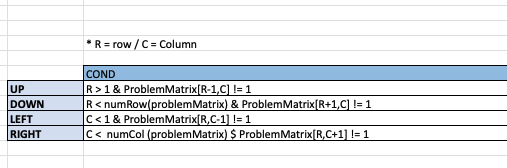

In [ ]:
is.applicableNO = function (state,action,problem){

  result = FALSE
  
    if(action=="UP" & state$state[1] > 1){
      if(state$problemMatrix[state$state[1]-1, state$state[2]] != 1){
        result = TRUE 
      }
    }
    if(action=="DOWN" & state$state[1] < nrow(state$problemMatrix)){
      if(state$problemMatrix[state$state[1]+1, state$state[2]] != 1){ 
        result = TRUE 
      }
    }
    if(action=="LEFT" & state$state[2] > 1){
      if(state$problemMatrix[state$state[1], state$state[2]- 1] != 1){ 
        result = TRUE
      }
    }
    if(action=="RIGHT" & state$state[2] < ncol(state$problemMatrix)){
      if(state$problemMatrix[state$state[1], state$state[2]+ 1] != 1){
        result = TRUE
      }
    }
  return(result)
}

    is.applicable(state, action, problem)
- ---------
This function will analize the same as the previous one, adding a new condition.
> The movement will only be applied if the value of the next cell contains the value of the **first not collected target** OR when the **cell is empty** (value == 0)

In [ ]:
is.applicable = function (state,action,problem){
  # this variable will store the value of the first not collected target
  minMatrix = min(state$problemMatrix[state$problemMatrix>1])

  result = FALSE
  
    if(action=="UP" & state$state[1] > 1){
      if(state$problemMatrix[state$state[1]-1, state$state[2]] != 1){
        if(state$problemMatrix[state$state[1]-1, state$state[2]] == minMatrix | state$problemMatrix[state$state[1]-1, state$state[2]]==0){
          result = TRUE
        }
      }
    }

    if(action=="DOWN" & state$state[1] < nrow(state$problemMatrix)){
      if(state$problemMatrix[state$state[1]+1, state$state[2]] != 1){
        if (state$problemMatrix[state$state[1]+ 1, state$state[2]] == minMatrix |state$problemMatrix[state$state[1]+ 1, state$state[2]] == 0){
          result = TRUE
        }   
      }
    }
    if(action=="LEFT" & state$state[2] > 1){
      if(state$problemMatrix[state$state[1], state$state[2]- 1] != 1){
        if(state$problemMatrix[state$state[1], state$state[2]-1] == minMatrix |state$problemMatrix[state$state[1], state$state[2]-1] == 0){
          result = TRUE
        }
      }
    }
    if(action=="RIGHT" & state$state[2] < ncol(state$problemMatrix)){
      if(state$problemMatrix[state$state[1], state$state[2]+ 1] != 1){
        if (state$problemMatrix[state$state[1], state$state[2]+1] == minMatrix |state$problemMatrix[state$state[1], state$state[2]+1] == 0){
          result = TRUE
        }
      }
    }

  return (result)
}

In [ ]:
#result1 = is.applicable(state=problem$state.initial, action="UP", problem=problem)
#result2 = is.applicable(state=c(1,1), action="LEFT", problem=problem)
#result3 = is.applicable(state=c(4,1), action="DOWN", problem=problem)
#result4 = is.applicable(state=c(4,4), action="RIGHT", problem=problem)
#result5 = is.applicable(state=c(4,1), action="LINE", problem=problem)

# should be false
#print(result1)
# should be false
#print(result2)
# should be false
#print(result3)
# should be false
#print(result4)
# should be false
#print(result5)

## Effect
It must return the state resulting on applying the action over the state

    effect = function (state,action)
-------
This function will calculate the effect of making a certain movement. The basic idea is that we are going to update the matrix, placing a 1 in each cell that the robot crosses and transforming it into a forbidden cell.

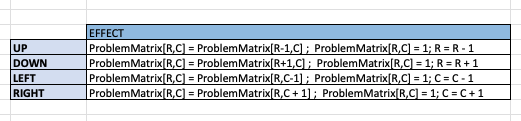

In [ ]:
effect = function (state,action){
  
  result = state
  
  if(action=="UP"){
    result$state[1] = result$state[1]-1
  }
  if(action=="DOWN"){
    result$state[1] = result$state[1]+1
  }
  if(action=="LEFT"){
    result$state[2] = result$state[2]-1
  }
  if(action=="RIGHT"){
    result$state[2] = result$state[2]+1
  }

  result$state[3] =  result$state[3] + (result$problemMatrix[result$state[1],result$state[2]]) 
  result$problemMatrix[result$state[1], result$state[2]] = 1
  
  return(result)
}

In the following cell of code we have made a test in order to check the results.

In [ ]:
#action = "DOWN"
#state = problem$state.initial
#i = 0 
#while(i < 3){
 # if(is.applicable(state,action,problem)){
  #  result1 = effect(state, action)
   # print(result1)
    #i = i+ 1
    #state = result1
  #}
#}


## Final state check

It Must return TRUE or FALSE according with the state is final or not
** In case the final state is stablished by a condition, second argument could be omited


    is.final.state(state,finalstate)
- -----
Final state check is in charge of checking whether if we have reach the final state or not. In our case it is just a condition. **We only have to check if the robot is on the last target and the value of the counter is the sum of all the targets.** Only when all this conditions are fulfilled we can say say that we are on the final state.

In [ ]:
is.final.state = function(state,finalstate){
  result = FALSE
  if(state$state[1] == finalstate[1] & state$state[2] == finalstate[2] & state$state[3] == finalstate[3]){
    result = TRUE 
  }
  return (result)
}

In [ ]:
#finalstate = problem$state.final
#state = problem$state.initial
#result = is.final.state(state, finalstate)
#print(result)

## Print a state

This function must print the state in console (in a legible way)


In [ ]:
library(glue)

to.string = function (state){
  print(glue("The current position is [{state$state[1]},{state$state[2]}]"))
  print(glue("The current value of the counter is {state$state[3]}"))
  print(glue("This is the matrix right now"))
  print(state$problemMatrix)
}

In [ ]:
#to.string(problem$state.initial)

## Cost calculation

It should return the cost of applying an action over a state


In [ ]:
get.cost = function (action,state){
  return (1)
}

## Evaluation

This function does not need a definition we can just leave it like this

In [ ]:
get.evaluation= function (state, problem){
  return(1)
}

# Solving and comparison

🚨 (You are asked for modifications here)

## Initialize the problem 

And check everything goes well :)

You don't need extra files to execute the code. Using the bellow formulary you can select the robot to solve the problem.

In [ ]:
#@title FILES
robot <- "https://raw.githubusercontent.com/HaizeaR/Sistemas-Inteligentes-Files/main/robot-1.txt" #@param ["https://raw.githubusercontent.com/HaizeaR/Sistemas-Inteligentes-Files/main/robot-1.txt", "https://raw.githubusercontent.com/HaizeaR/Sistemas-Inteligentes-Files/main/robot-2.txt", "https://raw.githubusercontent.com/HaizeaR/Sistemas-Inteligentes-Files/main/robot-3.txt", "https://raw.githubusercontent.com/HaizeaR/Sistemas-Inteligentes-Files/main/robot-4.txt", "https://raw.githubusercontent.com/HaizeaR/Sistemas-Inteligentes-Files/main/robot-5.txt", "https://raw.githubusercontent.com/HaizeaR/Sistemas-Inteligentes-Files/main/robot-6.txt"]


In [ ]:
problem = initialize.problem(robot)
print(problem)

Warning message in readLines(file):
“incomplete final line found on 'https://raw.githubusercontent.com/HaizeaR/Sistemas-Inteligentes-Files/main/robot-1.txt'”


     [,1] [,2]
[1,]    1    1
[2,]    3    3
[3,]    4    4
$state.initial
$state.initial$state
[1] 1 4 0

$state.initial$problemMatrix
     [,1] [,2] [,3] [,4]
[1,]    2    0    0    1
[2,]    0    0    0    0
[3,]    0    0    3    0
[4,]    0    0    0    4


$state.final
[1] 4 4 9

$actions.possible
  direction
1        UP
2      DOWN
3      LEFT
4     RIGHT

$name
[1] "Assignment 02"



## Experiment

Use different methods (and different parameters) to solve the problem

[1] Solution found!!
The current position is [4,4]
The current value of the counter is 9
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    1    1    1    1
[2,]    1    0    0    0
[3,]    1    1    1    0
[4,]    0    0    1    1
[1] Actions: 
       [,1] 
action LEFT 
action LEFT 
action LEFT 
action DOWN 
action DOWN 
action RIGHT
action RIGHT
action DOWN 
action RIGHT


   user  system elapsed 
  0.750   0.016   0.830 

[1] Solution found!!
The current position is [4,4]
The current value of the counter is 9
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    1    1    1    1
[2,]    1    0    0    0
[3,]    1    1    1    0
[4,]    0    0    1    1
[1] Actions: 
       [,1] 
action LEFT 
action LEFT 
action LEFT 
action DOWN 
action DOWN 
action RIGHT
action RIGHT
action DOWN 
action RIGHT


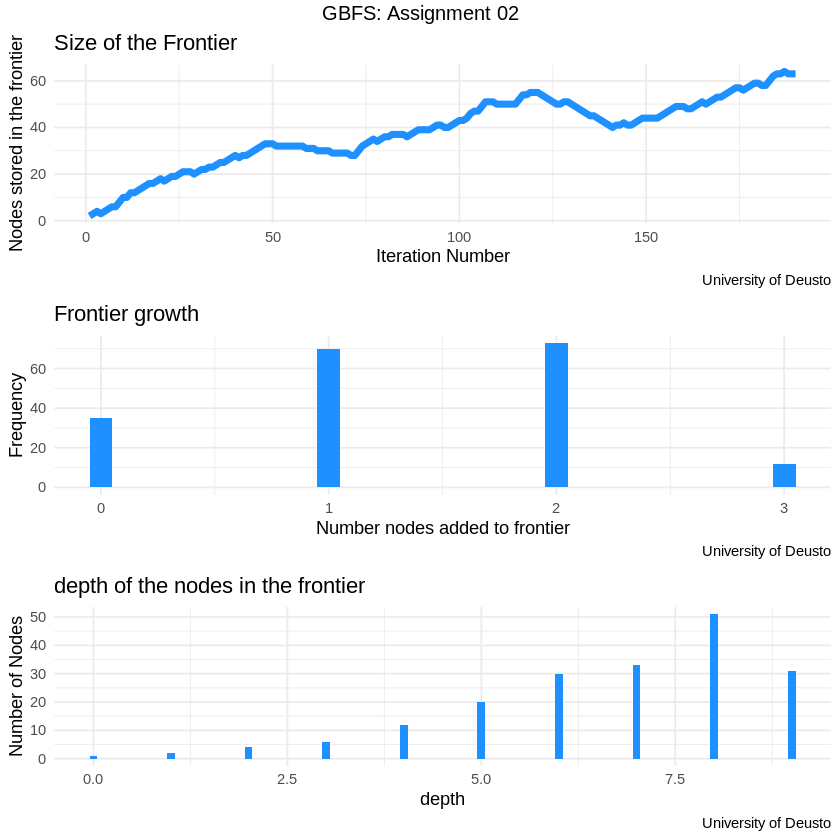

   user  system elapsed 
  0.619   0.000   0.621 

[1] Solution found!!
The current position is [4,4]
The current value of the counter is 9
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    1    1    1    1
[2,]    1    0    0    0
[3,]    1    1    1    0
[4,]    0    0    1    1
[1] Actions: 
       [,1] 
action LEFT 
action LEFT 
action LEFT 
action DOWN 
action DOWN 
action RIGHT
action RIGHT
action DOWN 
action RIGHT


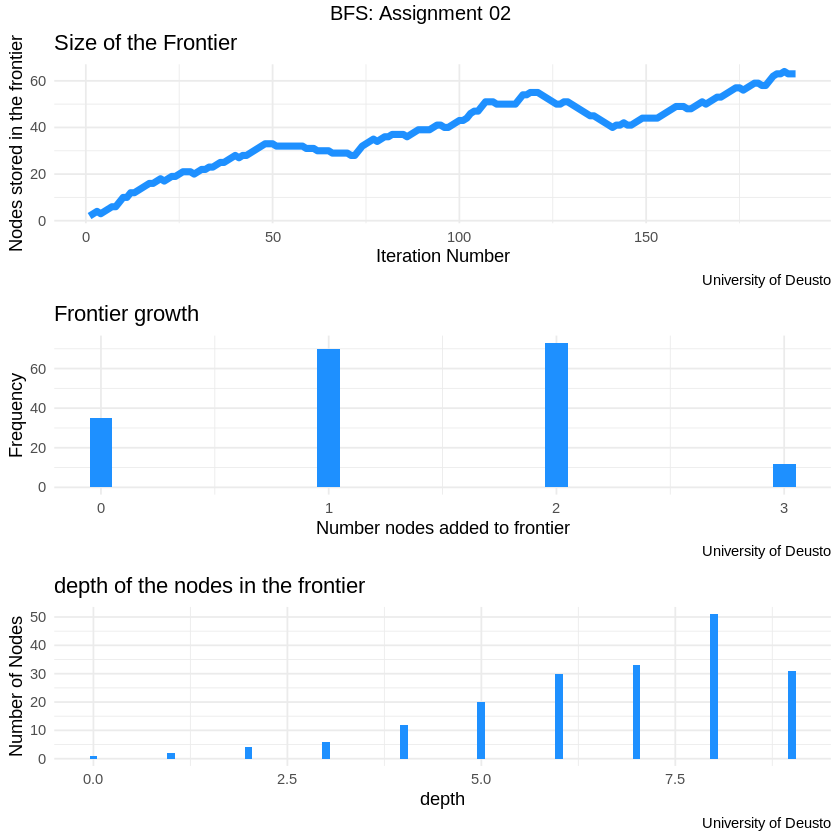

   user  system elapsed 
  0.547   0.005   0.554 

[1] Solution found!!
The current position is [4,4]
The current value of the counter is 9
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    1    1    1    1
[2,]    1    1    1    1
[3,]    1    1    1    1
[4,]    1    1    1    1
[1] Actions: 
       [,1] 
action LEFT 
action LEFT 
action LEFT 
action DOWN 
action RIGHT
action RIGHT
action RIGHT
action DOWN 
action LEFT 
action LEFT 
action LEFT 
action DOWN 
action RIGHT
action RIGHT
action RIGHT


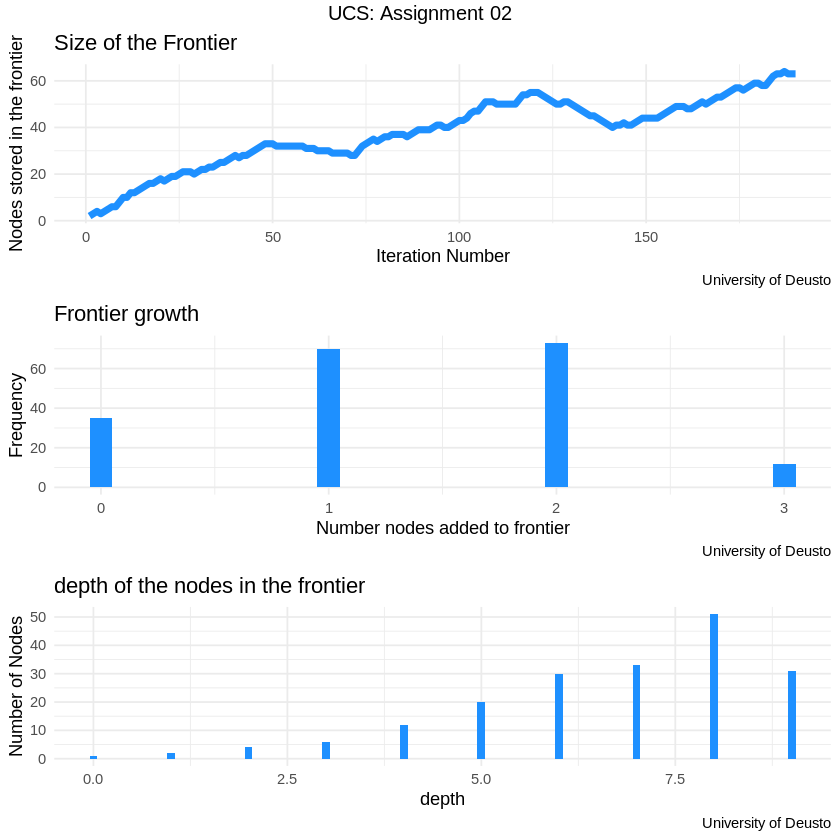

   user  system elapsed 
  0.449   0.000   0.452 

[1] Solution found!!
The current position is [4,4]
The current value of the counter is 9
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    1    1    1    1
[2,]    1    1    1    1
[3,]    1    1    1    1
[4,]    1    1    1    1
[1] Actions: 
       [,1] 
action LEFT 
action LEFT 
action LEFT 
action DOWN 
action RIGHT
action RIGHT
action RIGHT
action DOWN 
action LEFT 
action LEFT 
action LEFT 
action DOWN 
action RIGHT
action RIGHT
action RIGHT


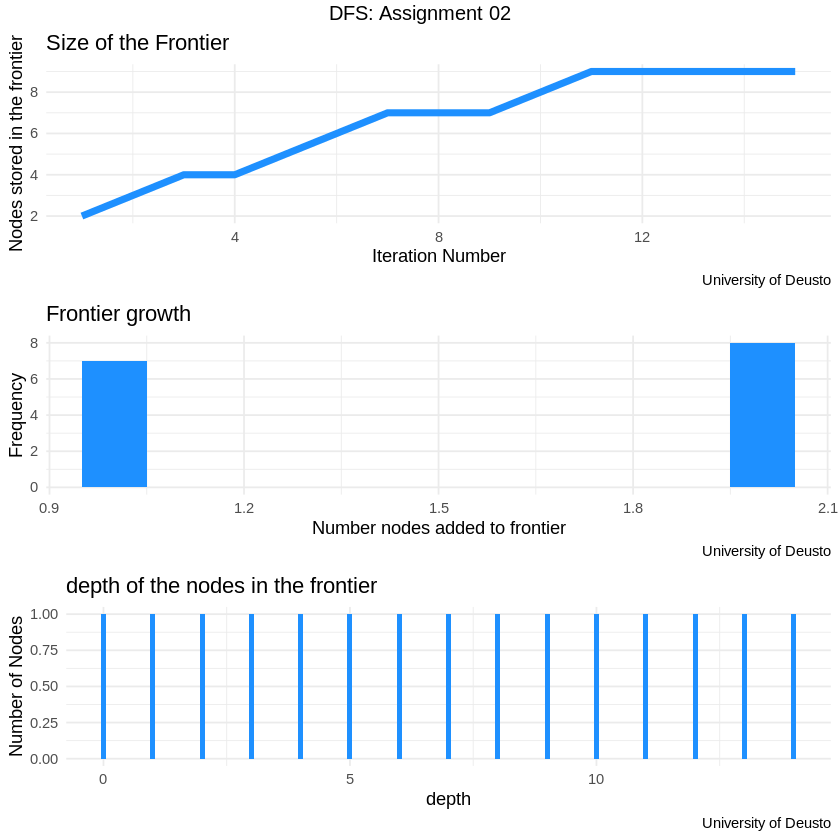

   user  system elapsed 
  0.451   0.001   0.454 

[1] Solution found!!
The current position is [4,4]
The current value of the counter is 9
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    1    1    1    1
[2,]    1    1    1    0
[3,]    0    0    1    1
[4,]    0    0    0    1
[1] Actions: 
       [,1] 
action LEFT 
action LEFT 
action LEFT 
action DOWN 
action RIGHT
action RIGHT
action DOWN 
action RIGHT
action DOWN 


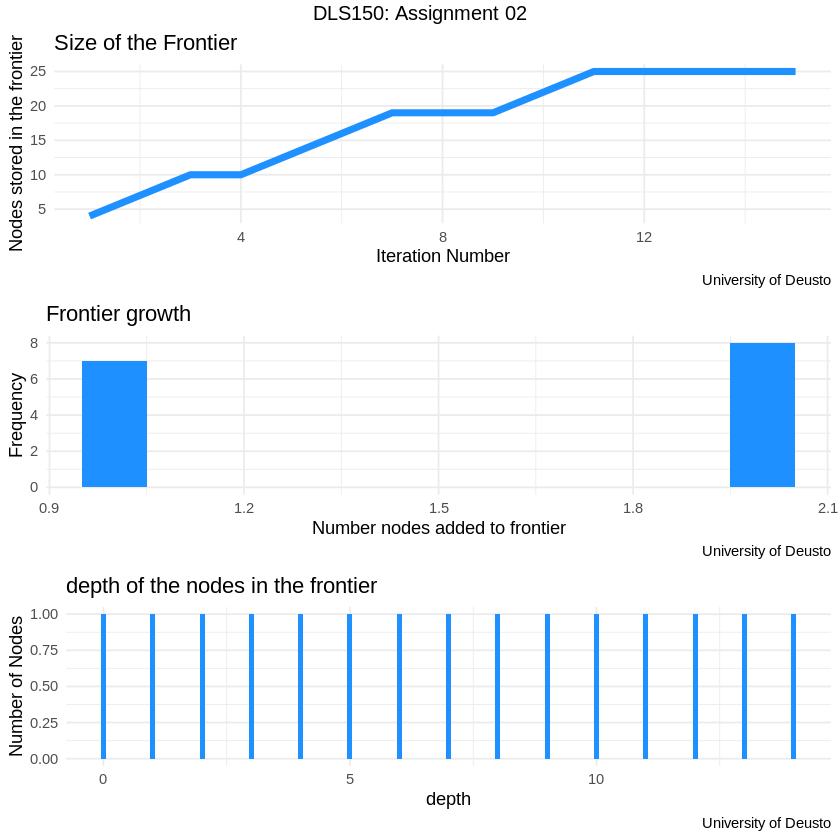

   user  system elapsed 
  0.779   0.001   0.786 

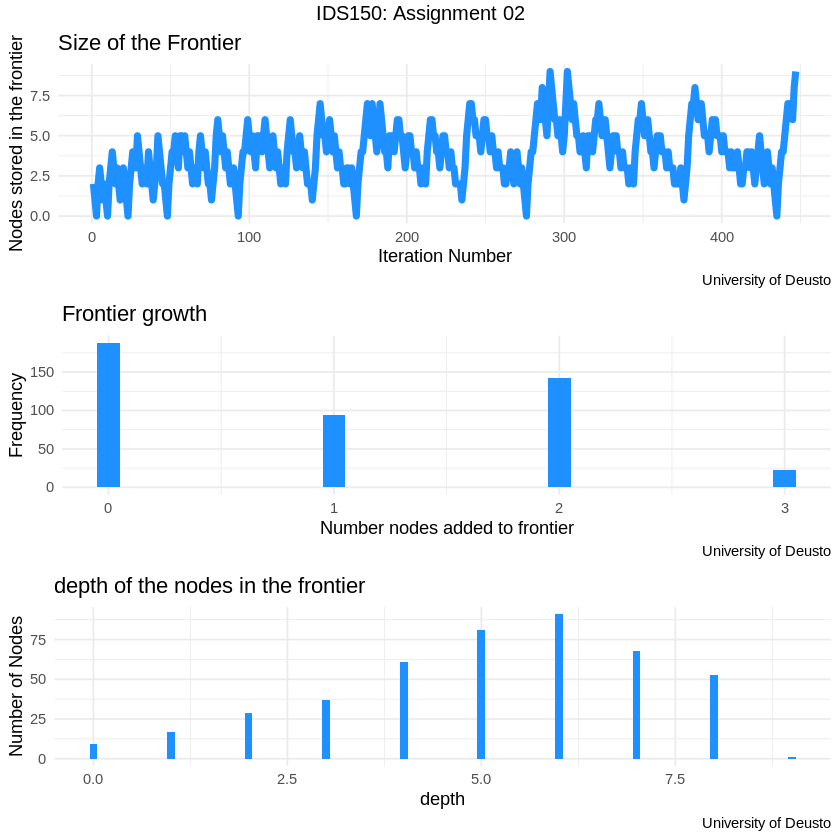

In [ ]:
system.time({
resGBFS = Greedy.Best.First.Search(problem,count.limit=10000, count.print = 10000, trace = FALSE )
})
system.time({
resBFS = Breadth.First.Search(problem,count.limit = 10000,  count.print = 10000,  trace = FALSE, graph.search = FALSE)
})
system.time({
resUCS = Uniform.Cost.Search(problem,count.limit=10000,  count.print = 10000, trace = FALSE)
})
system.time({
resDFS = Depth.First.Search(problem,count.limit=10000, count.print = 10000,  trace = FALSE,  graph.search = FALSE)
})
system.time({
resDLS = Depth.Limited.Search(problem, count.limit=10000, count.print = 10000, trace = FALSE, graph.search = FALSE, depth.limit = 150)
})
system.time({
resIDS = Iterative.Deepening.Search(problem,count.limit=10000, count.print =10000, trace = FALSE, graph.search = FALSE, depth.limit = 150)
})
#xxx

## Analyze

Compare and discuss results obtained

In [ ]:
all = list(resGBFS, resBFS, resDFS, resUCS,resDLS,resGBFS,resIDS)
analyze.results(all, problem)

[1] "GBFS"
[1]   Solution Found! :)
[1] "Initial State: "
The current position is [1,4]
The current value of the counter is 0
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    2    0    0    1
[2,]    0    0    0    0
[3,]    0    0    3    0
[4,]    0    0    0    4
[1] After applying action: LEFT
The current position is [1,3]
The current value of the counter is 0
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    2    0    1    1
[2,]    0    0    0    0
[3,]    0    0    3    0
[4,]    0    0    0    4
[1] After applying action: LEFT
The current position is [1,2]
The current value of the counter is 0
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    2    1    1    1
[2,]    0    0    0    0
[3,]    0    0    3    0
[4,]    0    0    0    4
[1] After applying action: LEFT
The current position is [1,1]
The current value of the counter is 2
This is the matrix right now
     [,1] [,2] [,3] [,4]
[1,]    1    1    1    1
[2,]    0    0    0    0
[3,]    

name,solution,length,cost,expanded,max.depth,max.frontier
<chr>,<lgl>,<int>,<dbl>,<int>,<dbl>,<int>
GBFS,TRUE,9,9,190,9,64
BFS,TRUE,9,9,190,9,64
DFS,TRUE,15,15,15,14,9
UCS,TRUE,9,9,190,9,64
DLS150,TRUE,15,15,15,14,25
GBFS,TRUE,9,9,190,9,64
IDS150,TRUE,9,9,447,9,9


###Results Robot 1

Timings:

>**GBFS**: 0.577
>
>**BFS**: 0.556
>
>**DFS**: 0.736
>
>**UCS**: 0.457
>
>**DLS**: 0.459
>
>**GBF**: 0.815
>
>**IDS**: 0.788

We can conclude that there is no big difference in the time needed by each algorithm.

The big difference between the DFS and the BFS algorithm is that both of them can find a solution but DFS won't ensure that the solution found is the optimal one. In this example we can clearly see the drawback of the DFS algorithm. 


**BFS**

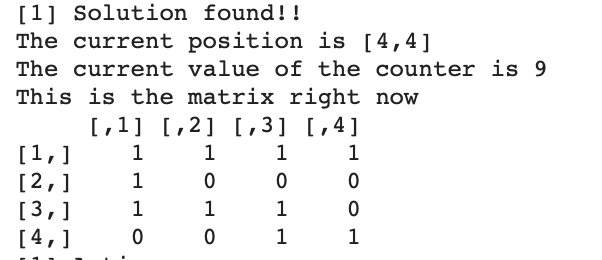

**DFS**

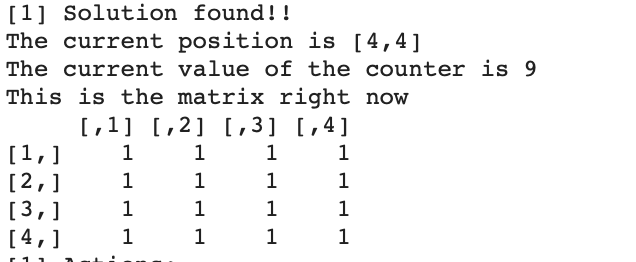

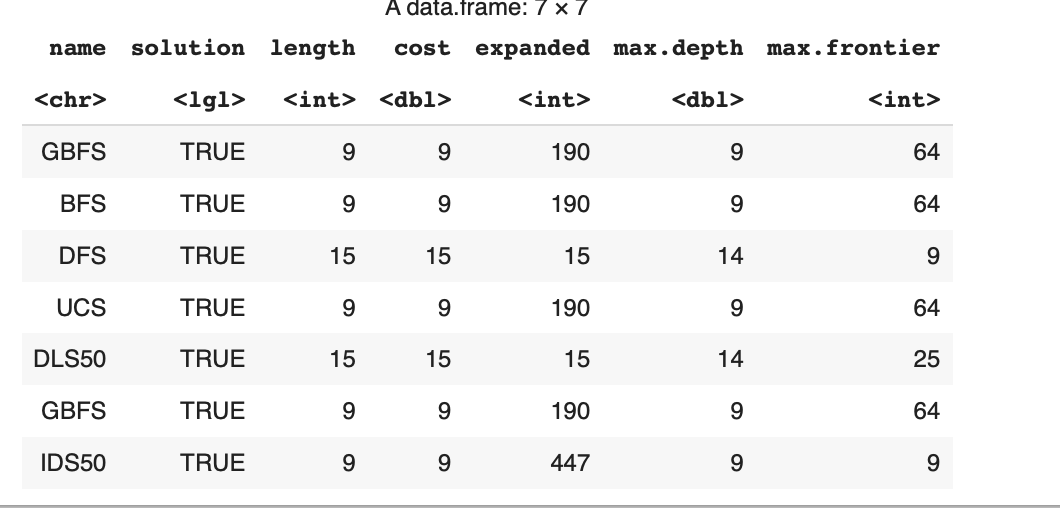

This problem has a lot of possible paths to solve it, so it is comprehensible that the max.frontier values and the expanded values are high. 

DFS and DLS50 have not found an optimal solution, for this reason the length and the cost is 15 and not 9. Because of this, the expanded value is so small compared to the others. 



####is.applicable

We have defined two is.applicable methods. All the problems are solved with the more "complex" one, but in order to be sure that this "complex" method is better then the simpler one we have made a little analysis. 

Timings:

>**GBFS**: 1.192
>
>**BFS**: 0.942
>
>**DFS**: 1.153
>
>**UCS**: 0.508
>
>**DLS**: 0.474
>
>**GBF**: 1.264
>
>**IDS**: 1.173

The timming compared to the upper results seem to be higher. This may not be really notizable this time but it proves that the other method, the "complex" one, solves it faster. In a situation with more iterations this timming difference will have an impact. 

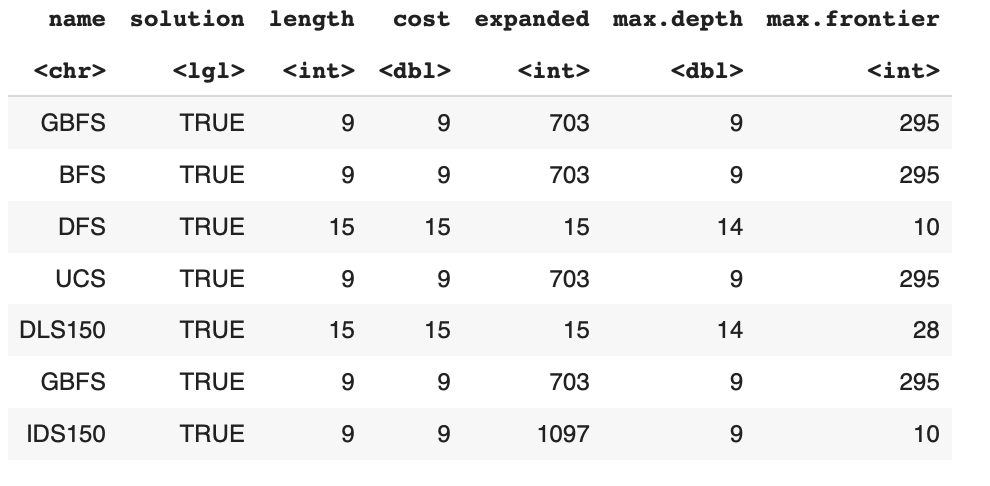

As we can see in the table the number are not as good as the previous ones. The algorithms have a greater frontier and need more nodes on the expansion. This proves that the "**complex" function is  better** and that we have taken the best option, making the solving of the problem a little bit more optimal. 

###Results Robot 2

Here are the time in seconds that each algorithm used to solve the problem
Timings:

>**GBFS**: 0.420
>
>**BFS**: 0.430
>
>**DFS**: 0.432
>
>**UCS**: 0.419
>
>**DLS**: 0.454
>
>**GBF**: 0.519
>
>**IDS**:  0.470

We can conclude that there is no big difference in the time needed by each algorithm.


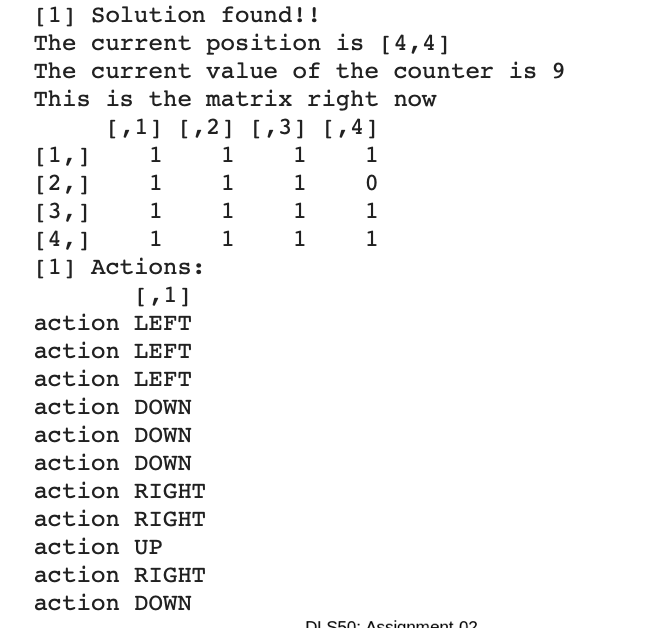

As we can see in the table all the algorithms solved the problem in the same amount of steps and provided exactly the same solution, which makes sense because the matrix is really small and there are not a lot of possibilities. Furthermore, the solution found is the best solution.   

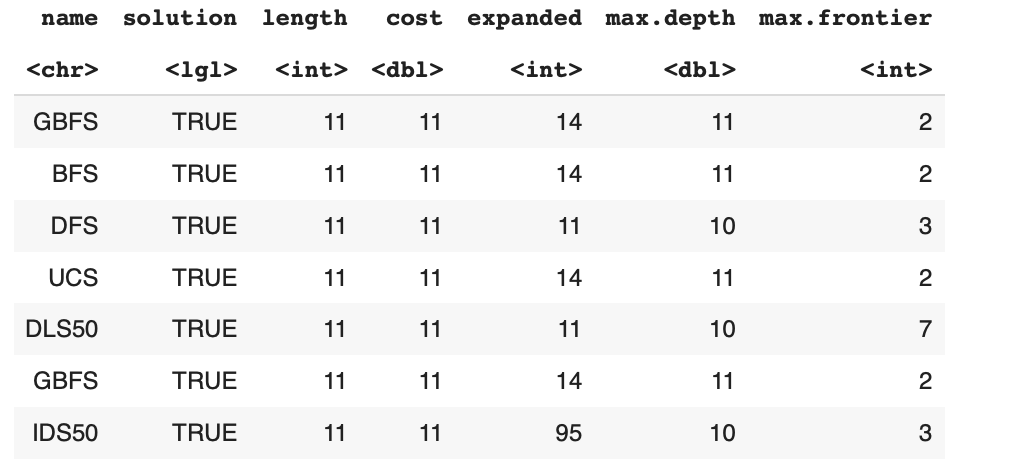

DLS and IDS algorithms would not work with a depth limit of 10 so we increase it to 50 to get a solution. DLS50 has the highest number of nodes on the frontier and IDS, which is an iteretive algorithm, has a really high expansion number. 


In the case of BFS and DFS we know that DFS might find a solution but we won't be sure if it is the optimal one, whereas BFS will find a solution and we can be sure that it is the optimal one. Becasue the solution is the same for both of them we can conclude that DFS has found the optimal solution. 

###Results Robot 3 and Robot 4


We have decided to analyse both this files together. We are not able to check if they can solve the problem or not because we reach the maximum number of iterations. We have tried to increase the count limit up to 10000000 but after three long hours of waiting it did not provide an answer.

We cannot provide a lot of explanations about this cases, we can just say that becasue there is a really high number of possible solutions it takes a really long time for the algorithm to find them. 



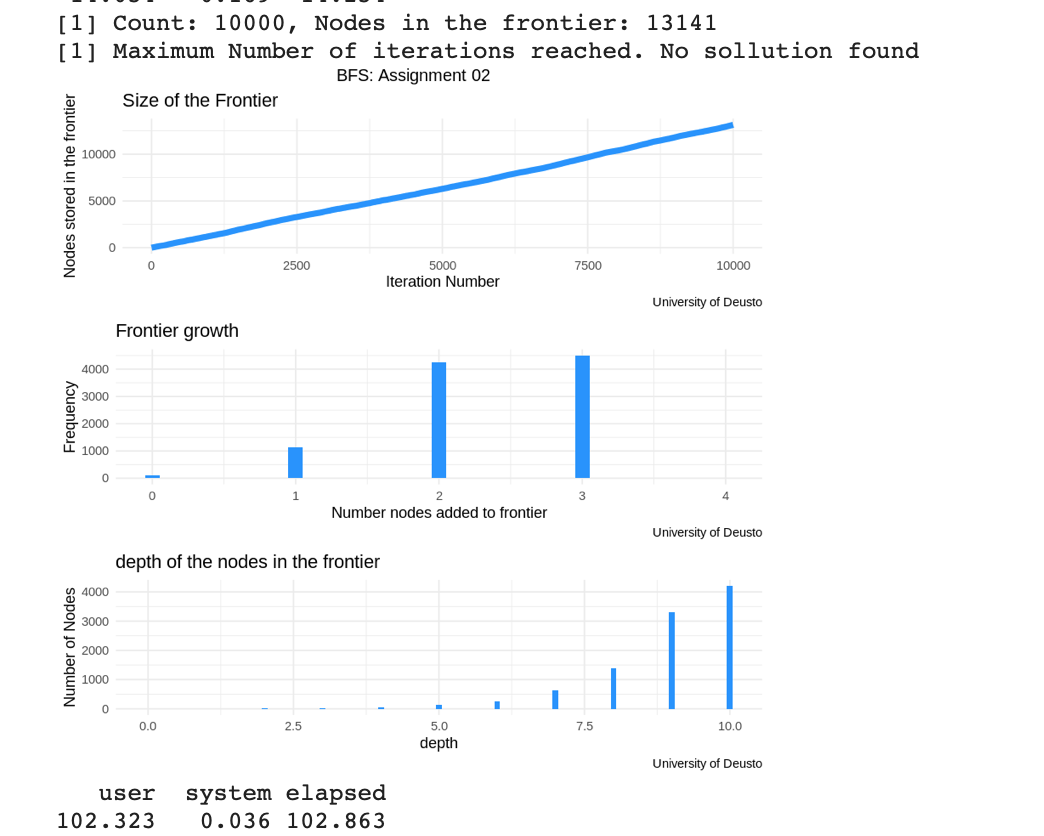

## Does the order of the assembly points affect the final result?

- Write the needed code to initialize one (or more) problem(s) with the order of the tasks are altered.
- Use different methods to solve the different variants of the problem.
- Compare and analyze results

(Use as many code or text blocks to ensure the code, analysis and conclusions extracted are clearly exposed)

The answer to this question depends on the specific matrix. If we place the targets in a way that the robot won't be able to pick them in order, there won't be a solution. We are not analyzing this case becasue if we give the algorithm a problem with no solution the resoult will be, of course, no solution. 

We have tried the experiments making alterations to robot 1 and robot 2 and for that we have created two more files, **robot 5** and **robot 6**. 

###Results Robot 5

Robot 5 has the same structure as robot 1 with the assably points swapped. 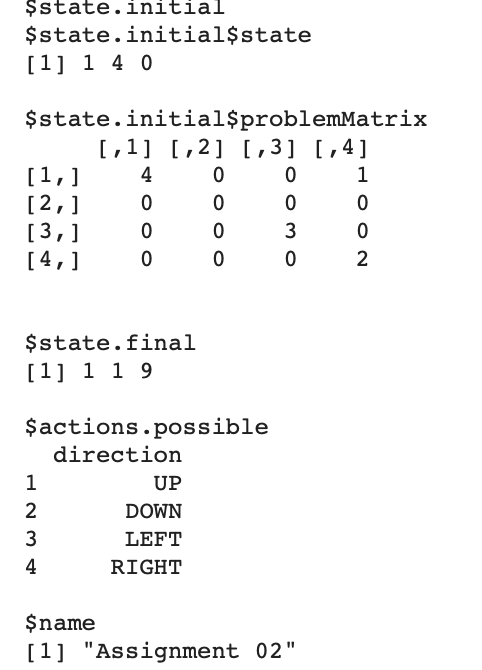

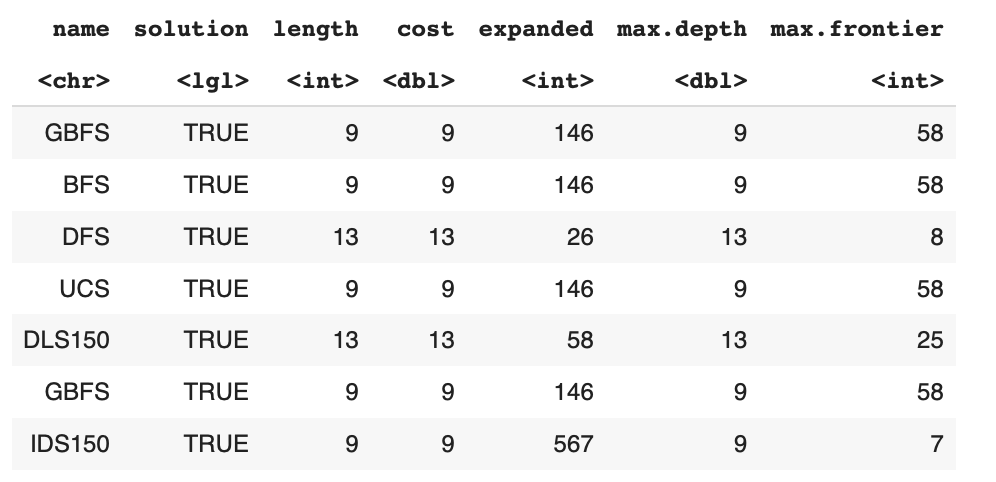

The changed made is not really big so it makes sense that the results are similar to the ones on robot 1. We can appreciate a little decrease in some variables like max.frontier and expanded nodes but appart from that all algorithms work similarly, even the ones that did not find an optimal solution are still not finding it. 

###Result Robot 6

The targets of this robot are placed "randomly". We have put them in a way that we can ensure a possible solution, but without following any logic. 

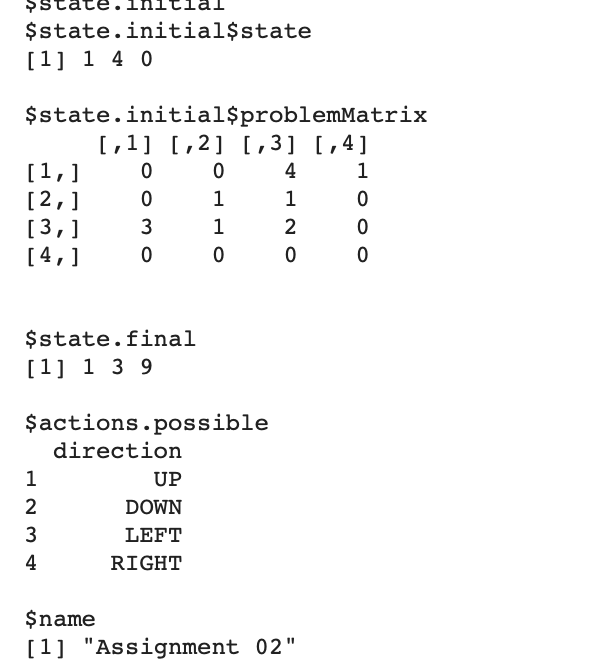

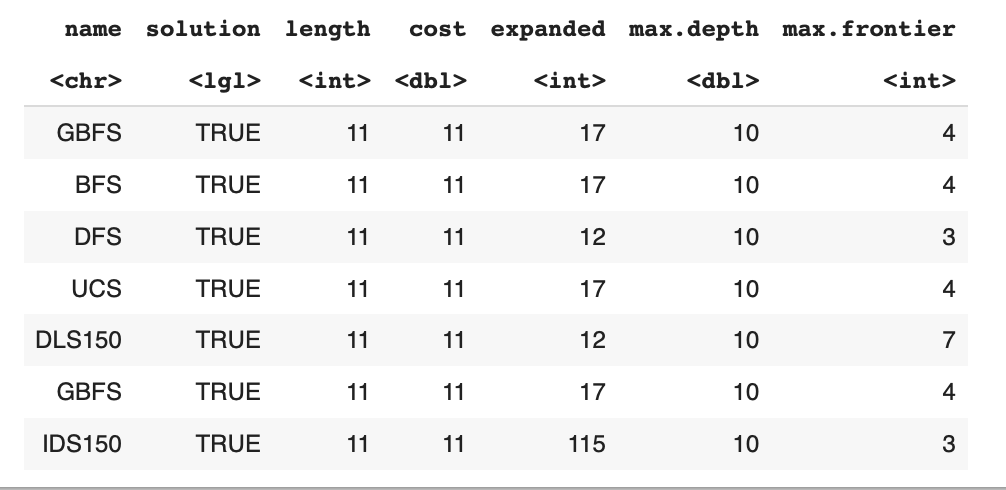

The results are really similar to the ones on the second robot, some of the values might be slightly higher but there is no big difference in time and resoults so we can conlude that after making this changes there are no great effects on the final results.

###Final comments

After analyzing all the possible robots we can say that what it truthly affects a problem is the **dimension of the matrix** itself, because there are **more possible ways to solve it**. It seems harder to find a solution when there are no forbidden points, which makes sense, because the forbidden points reduce the amount of paths thus, the number of iterations needed to find a solution. 